# Imports

In [1]:
# imports
import numpy as np
from tueplots import bundles, figsizes
import wandb
import matplotlib.pyplot as plt

import sys

%load_ext autoreload
%autoreload 2

sys.path.insert(0, '.')

In [2]:
from analysis import sweep2df, plot_typography


In [3]:
USETEX = True

In [4]:
plt.rcParams.update(bundles.neurips2022(usetex=USETEX))
plt.rcParams.update({
    'text.latex.preamble': [r'\usepackage{amsfonts}', # mathbb
                            r'\usepackage{amsmath}'] # boldsymbol
})

In [5]:
plot_typography(usetex=USETEX, small=12, medium=16, big=20)

In [6]:
# Constants
ENTITY = "causal-representation-learning"
PROJECT = "sam_test"

# W&B API
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)

# Data loading

## SAM and VAE sanity check

In [59]:
SWEEP_ID = "e0geelo2"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sam_vae_{SWEEP_ID}"
df_sam_vae, sam_val_loss, sam_val_scale_inv = sweep2df(sweep.runs, filename, save=True, load=False)

/Users/patrik.reizinger/Documents/GitHub/vae-sam/analysis/./analysis.py:145: RuntimeWarning: divide by zero encountered in double_scalars
  val_scale_inv4min_val_loss,
/Users/patrik.reizinger/Documents/GitHub/vae-sam/analysis/./analysis.py:145: RuntimeWarning: divide by zero encountered in double_scalars
  val_scale_inv4min_val_loss,
/Users/patrik.reizinger/Documents/GitHub/vae-sam/analysis/./analysis.py:145: RuntimeWarning: divide by zero encountered in double_scalars
  val_scale_inv4min_val_loss,
/Users/patrik.reizinger/Documents/GitHub/vae-sam/analysis/./analysis.py:145: RuntimeWarning: divide by zero encountered in double_scalars
  val_scale_inv4min_val_loss,
/Users/patrik.reizinger/Documents/GitHub/vae-sam/analysis/./analysis.py:145: RuntimeWarning: divide by zero encountered in double_scalars
  val_scale_inv4min_val_loss,
/Users/patrik.reizinger/Documents/GitHub/vae-sam/analysis/./analysis.py:145: RuntimeWarning: divide by zero encountered in double_scalars
  val_scale_inv4min_va

## Fix encoder variance

In [53]:
SWEEP_ID = "4aggfh82"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"fix_enc_var_sweep_{SWEEP_ID}"
df_fix_enc_var, fix_enc_val_loss, fix_enc_val_scale_inv = sweep2df(sweep.runs, filename, save=True, load=False)

## RAE

In [54]:
SWEEP_ID = "kmnl40of"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"rae_sweep_{SWEEP_ID}"
df_rae, rae_val_loss, rae_val_scale_inv = sweep2df(sweep.runs, filename, save=True, load=False)

# Pre-processing


In [45]:
enc_vars = df_fix_enc_var.enc_var.unique()

## SAM and VAE sanity check

In [ ]:
scale_no_sam = sam_val_scale_inv[ df_sam_vae.sam_update ==False]
scale_sam = sam_val_scale_inv[df_sam_vae.sam_update ==True]

loss_no_sam = sam_val_loss[ df_sam_vae.sam_update ==False]
loss_sam = sam_val_loss[df_sam_vae.sam_update ==True]

## Fix encoder variance

In [55]:
scale_enc_var_no_sam = {var: fix_enc_val_scale_inv[(df_fix_enc_var.enc_var == var) & (df_fix_enc_var.sam_update ==False)] for var in enc_vars}
scale_enc_var_sam = {var: fix_enc_val_scale_inv[(df_fix_enc_var.enc_var == var) & (df_fix_enc_var.sam_update ==True)] for var in enc_vars}

loss_enc_var_no_sam = {var: fix_enc_val_loss[(df_fix_enc_var.enc_var == var) & (df_fix_enc_var.sam_update ==False)] for var in enc_vars}
loss_enc_var_sam = {var: fix_enc_val_loss[(df_fix_enc_var.enc_var == var) & (df_fix_enc_var.sam_update ==True)] for var in enc_vars}

## RAE

In [56]:
scale_rae = {var: rae_val_scale_inv[df_rae.enc_var == var] for var in enc_vars}
loss_rae = {var: rae_val_loss[df_rae.enc_var == var] for var in enc_vars}

# Plots

## SAM and VAE sanity check

In [ ]:
LABELPAD = 1
TICK_PADDING = 2
COLORS = ["tab:blue","tab:orange","tab:green","tab:red"]
val_epoch_factor = 15

fig = plt.figure(figsize=figsizes.neurips2022(nrows=1, ncols=2, rel_width=2)['figure.figsize'])

"""Loss and inv scale"""
ax = fig.add_subplot(121)
ax.grid(True, which="both", ls="-.")


if len(scale_sam) > 0:
    val_epoch_ticks = range(0, scale_sam.shape[1] * val_epoch_factor, val_epoch_factor)
    ax.errorbar(val_epoch_ticks, np.log10(scale_sam).mean(0), np.log10(scale_sam).std(0), c=COLORS[0], label=f"SAM", ls="-")
    ax.errorbar(val_epoch_ticks, np.log10(scale_no_sam).mean(0), np.log10(scale_no_sam).std(0), c=COLORS[1], label="VAE", ls=":")


ax.set_xlabel("Epoch", labelpad=LABELPAD)
ax.set_ylabel("$\log_{10}\Vert\mathrm{\mathbf{J}}_{\mathbf{f}}\Vert$", labelpad=LABELPAD)


ax = fig.add_subplot(122)
ax.grid(True, which="both", ls="-.")


if len(loss_sam) > 0:
    val_epoch_ticks = range(0, loss_sam.shape[1] * val_epoch_factor, val_epoch_factor)
    ax.errorbar(val_epoch_ticks, loss_sam.mean(0), loss_sam.std(0), c=COLORS[0], label=f"SAM", ls="-")
    ax.errorbar(val_epoch_ticks, loss_no_sam.mean(0), loss_no_sam.std(0), c=COLORS[1], label="VAE", ls=":")



ax.set_xlabel("Epoch", labelpad=LABELPAD)
ax.set_ylabel("$\mathcal{L}$", labelpad=LABELPAD)


plt.legend(loc="upper right")
plt.savefig("loss_grad_sam_no_sam.svg")

## Fix encoder variance

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_39375/1928288362.py:18: RuntimeWarning: invalid value encountered in log10
  ax.errorbar(val_epoch_ticks, np.log10(inv_scale_no_sam).mean(0), np.log10(inv_scale_no_sam).std(0), c=color, label=str(var), ls=":")
/Users/patrik.reizinger/Documents/GitHub/vae-sam/venv/lib/python3.10/site-packages/matplotlib/axes/_base.py:2532: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


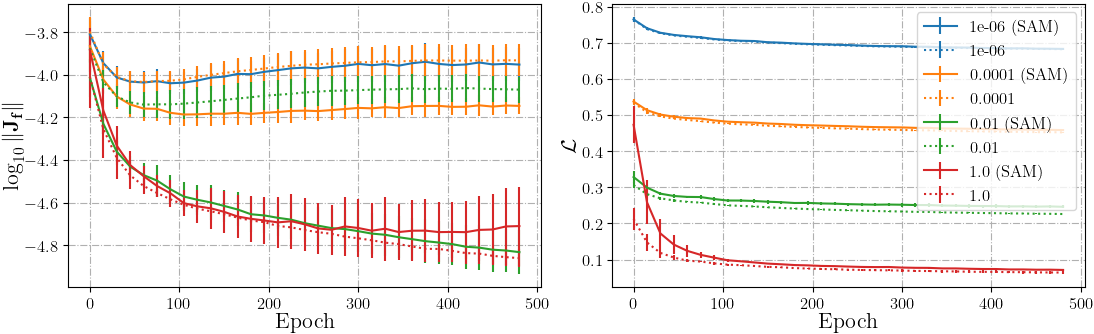

In [57]:
LABELPAD = 1
TICK_PADDING = 2
COLORS = ["tab:blue","tab:orange","tab:green","tab:red"]
val_epoch_factor = 15

fig = plt.figure(figsize=figsizes.neurips2022(nrows=1, ncols=2, rel_width=2)['figure.figsize'])

"""Loss and inv scale"""
ax = fig.add_subplot(121)
ax.grid(True, which="both", ls="-.")



for (var, inv_scale_sam), inv_scale_no_sam, inv_scale_rae, color in zip(scale_enc_var_sam.items(),scale_enc_var_no_sam.values(), scale_rae.values(), COLORS):
    if len(inv_scale_sam) > 0:
        val_epoch_ticks = range(0, len(inv_scale_sam[0]) * val_epoch_factor, val_epoch_factor)
        ax.errorbar(val_epoch_ticks, np.log10(inv_scale_sam).mean(0), np.log10(inv_scale_sam).std(0), c=color, label=f"{var} (SAM)", ls="-")
        ax.errorbar(val_epoch_ticks, np.log10(inv_scale_no_sam).mean(0), np.log10(inv_scale_no_sam).std(0), c=color, label=str(var), ls=":")

        # val_epoch_ticks = range(0, len(inv_scale_rae[0]) * val_epoch_factor, val_epoch_factor)
        # ax.errorbar(val_epoch_ticks, np.log10(inv_scale_rae).mean(0), np.log10(inv_scale_rae).std(0), c=color, label=f"{var} (RAE)", ls="-.")


ax.set_xlabel("Epoch", labelpad=LABELPAD)
ax.set_ylabel("$\log_{10}\Vert\mathrm{\mathbf{J}}_{\mathbf{f}}\Vert$", labelpad=LABELPAD)


ax = fig.add_subplot(122)
ax.grid(True, which="both", ls="-.")

for (var, l_sam), l_no_sam, l_rae, color in zip(loss_enc_var_sam.items(), loss_enc_var_no_sam.values(), loss_rae.values(), COLORS):
    if len(l_sam) > 0:
        val_epoch_ticks = range(0, len(l_sam[0]) * val_epoch_factor, val_epoch_factor)
        ax.errorbar(val_epoch_ticks, l_sam.mean(0), l_sam.std(0), c=color, label=f"{var} (SAM)", ls="-")
        ax.errorbar(val_epoch_ticks, l_no_sam.mean(0), l_no_sam.std(0), c=color, label=str(var), ls=":")

        # val_epoch_ticks = range(0, len(l_rae[0]) * val_epoch_factor, val_epoch_factor)
        # ax.errorbar(val_epoch_ticks, np.log10(l_rae).mean(0), np.log10(l_rae).std(0), c=color, label=f"{var} (RAE)", ls="-.")




ax.set_xlabel("Epoch", labelpad=LABELPAD)
ax.set_ylabel("$\mathcal{L}$", labelpad=LABELPAD)


plt.legend(loc="upper right")
plt.savefig("loss_grad_fix_enc_var.svg")

## RAE

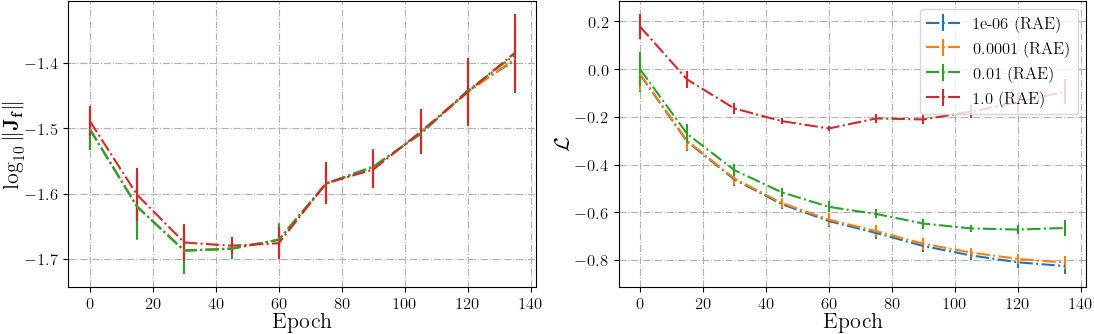

In [58]:
LABELPAD = 1
TICK_PADDING = 2
COLORS = ["tab:blue","tab:orange","tab:green","tab:red"]
val_epoch_factor = 15

fig = plt.figure(figsize=figsizes.neurips2022(nrows=1, ncols=2, rel_width=2)['figure.figsize'])

"""Loss and inv scale"""
ax = fig.add_subplot(121)
ax.grid(True, which="both", ls="-.")



for (var, inv_scale_rae), color in zip(scale_rae.items(), COLORS):
    if len(inv_scale_rae) > 0:
        val_epoch_ticks = range(0, len(inv_scale_rae[0]) * val_epoch_factor, val_epoch_factor)
        ax.errorbar(val_epoch_ticks, np.log10(inv_scale_rae).mean(0), np.log10(inv_scale_rae).std(0), c=color, label=f"{var} (RAE)", ls="-.")


ax.set_xlabel("Epoch", labelpad=LABELPAD)
ax.set_ylabel("$\log_{10}\Vert\mathrm{\mathbf{J}}_{\mathbf{f}}\Vert$", labelpad=LABELPAD)


ax = fig.add_subplot(122)
ax.grid(True, which="both", ls="-.")

for (var, l_rae), color in zip(loss_rae.items(), COLORS):
    if len(l_rae) > 0:
        val_epoch_ticks = range(0, len(l_rae[0]) * val_epoch_factor, val_epoch_factor)
        ax.errorbar(val_epoch_ticks, np.log10(l_rae).mean(0), np.log10(l_rae).std(0), c=color, label=f"{var} (RAE)", ls="-.")




ax.set_xlabel("Epoch", labelpad=LABELPAD)
ax.set_ylabel("$\mathcal{L}$", labelpad=LABELPAD)


plt.legend(loc="upper right")
plt.savefig("loss_grad_rae.svg")